In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d

plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
def get_nuclei_centroids(nuclei_img):
    PIXELS_BORDER = 20

    nuclei_img_expanded = cv2.copyMakeBorder(nuclei_img, PIXELS_BORDER, PIXELS_BORDER,
                                             PIXELS_BORDER, PIXELS_BORDER, cv2.BORDER_CONSTANT, 0)

    nuclei_img_gray = cv2.cvtColor(nuclei_img_expanded, cv2.COLOR_BGR2GRAY)

    # Enhance contrast (CLAHE - Contrast Limited Adaptive Histogram Equalization)

    clahe = cv2.createCLAHE(clipLimit=5.0)
    contrast_img = clahe.apply(nuclei_img_gray)

    # Blurring
    blur_img = cv2.GaussianBlur(contrast_img, (9,9),0)

    # Thresholding (Otsu)
    ret, thresh_img = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Noise removal
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=1)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.3*dist_transform.max(), 255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    markers_watershed = cv2.watershed(nuclei_img_expanded, markers)
    
    contours_img = np.zeros(markers_watershed.shape, dtype='uint8')
    contours_img[markers_watershed == -1] = 255

    contours, hierarchy = cv2.findContours(contours_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)    
    
    centroids = []

    contours = contours[:-2]
    for c in contours:
        moments = cv2.moments(c)
        area = moments['m00']
        cX = int(moments['m10'] / area) - PIXELS_BORDER
        cY = int(moments['m01'] / area) - PIXELS_BORDER
        centroids.append((cX, cY))

    centroids = np.array(centroids, dtype=int)
    
    return np.unique(centroids, axis=0)

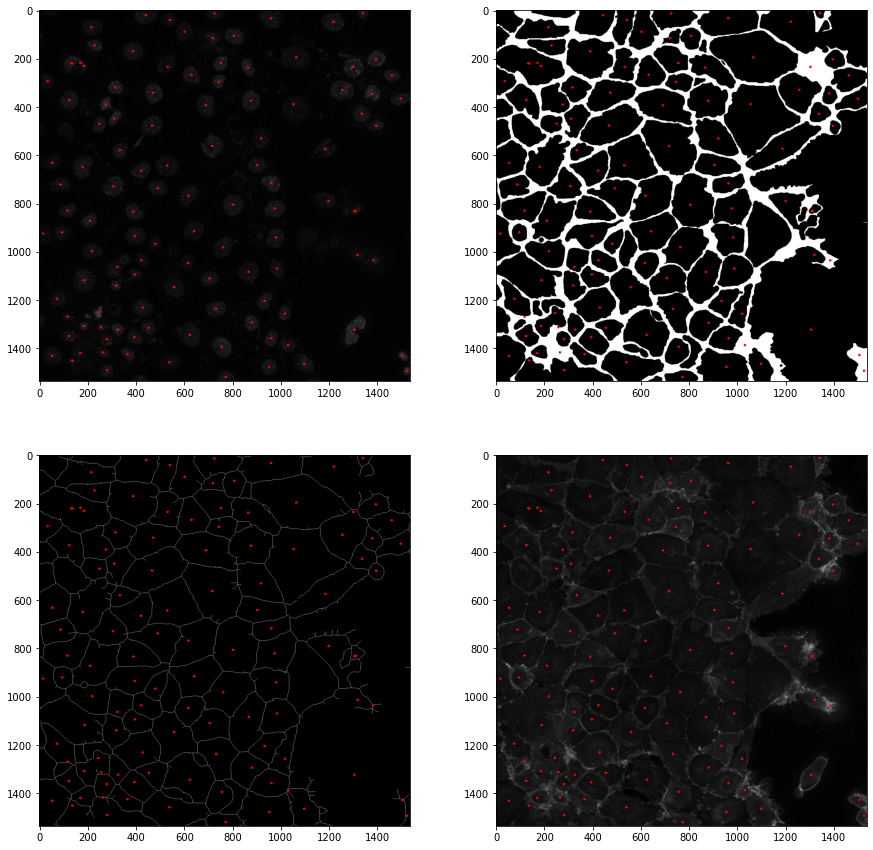

In [3]:
nuclei_path = 'mltest/AKT1_B1_CAn.tif'
jbin_path = 'mltest/AKT1_B1_CAj-BI.tif'
jsk_path = 'mltest/AKT1_B1_CAj-SK.tif'
j_path = 'mltest/AKT1_B1_CAj.tif'

nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)
jsk_img = cv2.imread(jsk_path)
j_img = cv2.imread(j_path)

centroids = get_nuclei_centroids(nuclei_img)

nuclei_centroids = nuclei_img.copy()
jbin_centroids = jbin_img.copy()
jsk_centroids = jsk_img.copy()
j_centroids = j_img.copy()


for x, y in centroids:
    cv2.circle(nuclei_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jsk_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(j_centroids, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids)
ax[0,1].imshow(jbin_centroids)
ax[1,0].imshow(jsk_centroids)
ax[1,1].imshow(j_centroids)

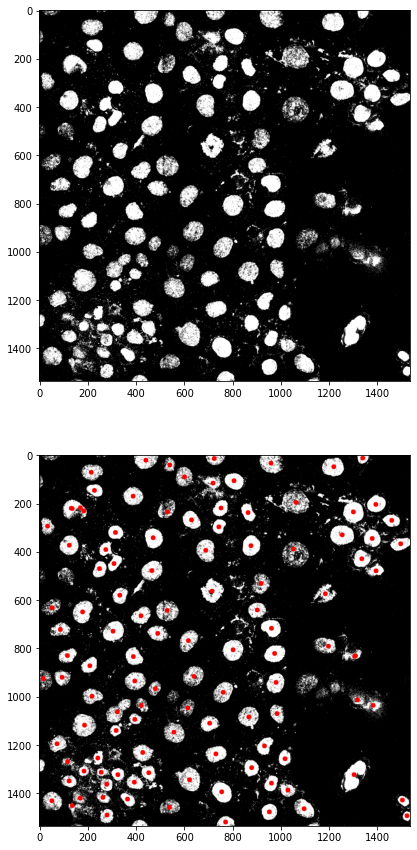

In [4]:
gray_nuclei = cv2.cvtColor(nuclei_img, cv2.COLOR_BGR2GRAY)
otsu_val = filters.threshold_otsu(gray_nuclei)
bin_nuclei = (255 - (gray_nuclei < otsu_val)*255).astype('uint8')
fig, ax = plt.subplots(2)
bin_nuclei_centroids = cv2.cvtColor(bin_nuclei, cv2.COLOR_GRAY2RGB)
for x, y in centroids:
    cv2.circle(bin_nuclei_centroids, (x, y), 10, (255, 0, 0), -1)

ax[0].imshow(bin_nuclei, cmap='gray')
ax[1].imshow(bin_nuclei_centroids)

In [5]:
vor = Voronoi(centroids)

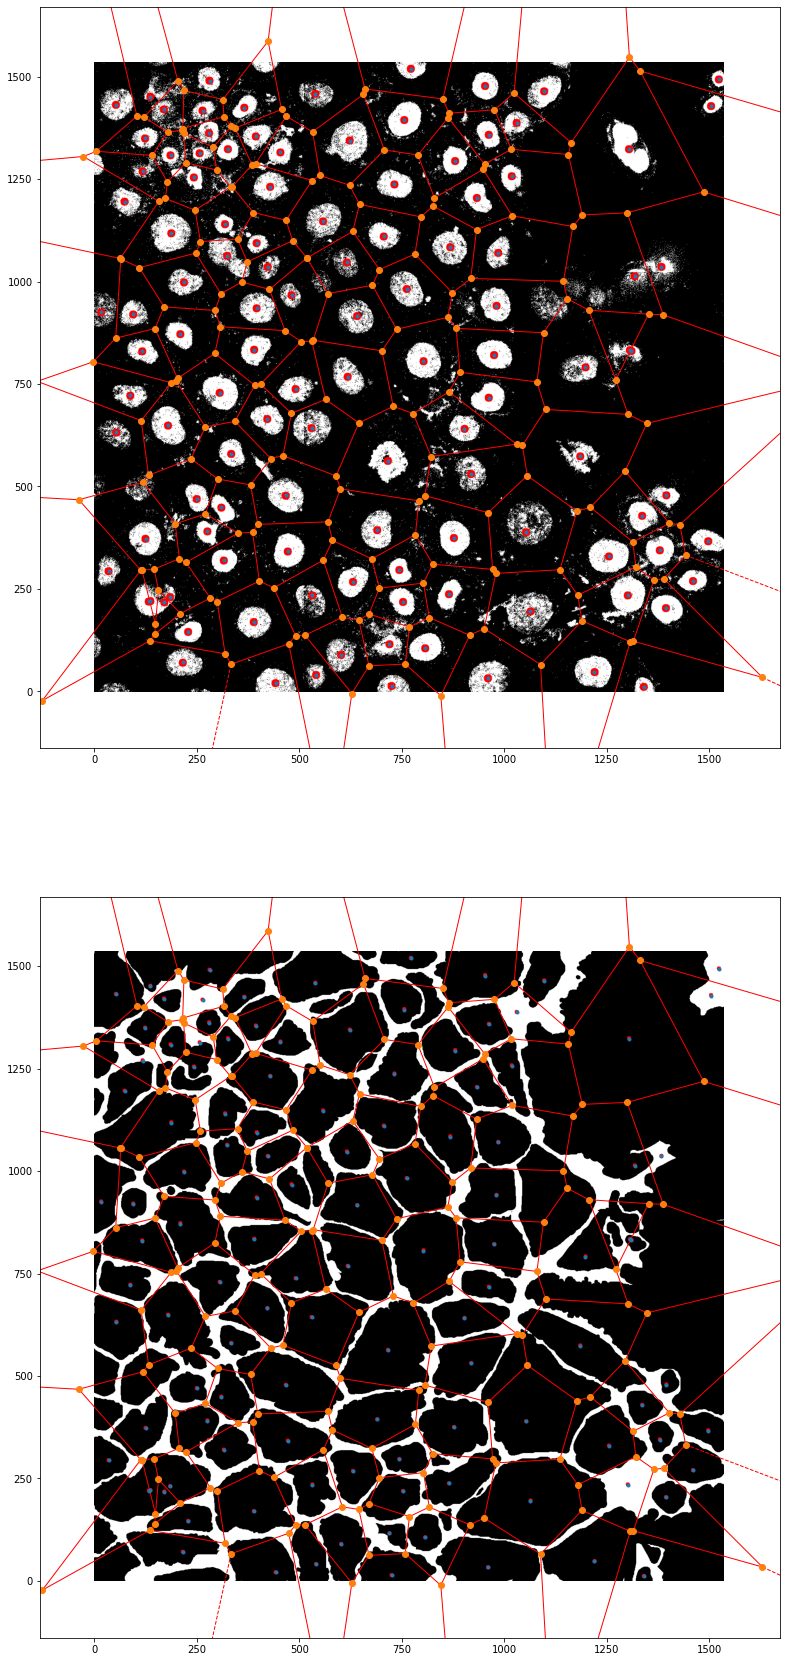

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(15,30))

voronoi_plot_2d(vor, line_colors='red', ax=axes[0])
axes[0].imshow(bin_nuclei_centroids)

voronoi_plot_2d(vor, line_colors='red', ax=axes[1])
axes[1].imshow(jbin_centroids)

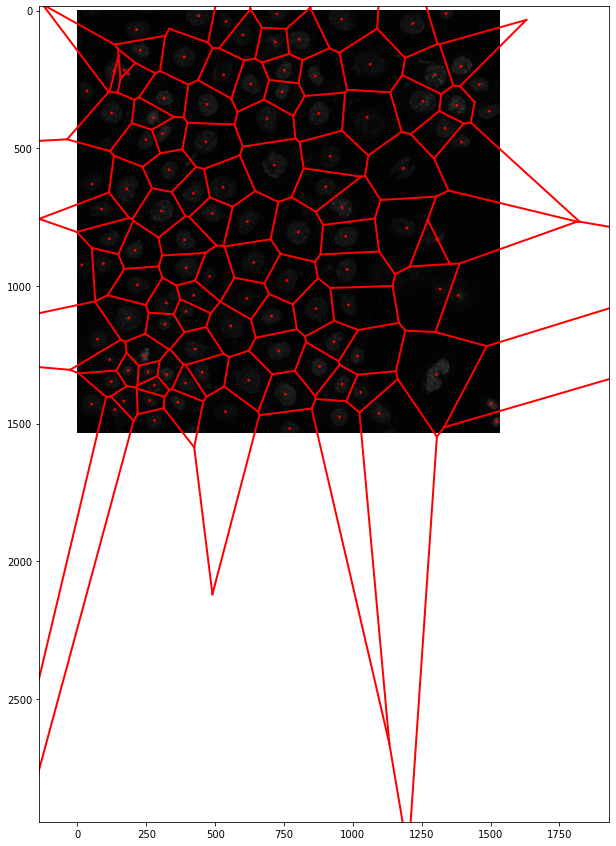

In [7]:
def rebuild_edges(vor):
    edges = []
    for vpair in vor.ridge_vertices:
        if vpair[0] >= 0 and vpair[1] >= 0:
            v0 = vor.vertices[vpair[0]]
            v1 = vor.vertices[vpair[1]]
            edges.append((v0, v1))
    return edges

edges = rebuild_edges(vor)
fig, ax = plt.subplots(1)
ax.imshow(nuclei_centroids)
for v0, v1 in edges:
    ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'r', linewidth=2)
ax.margins(x=-0.3, y=-0.3)

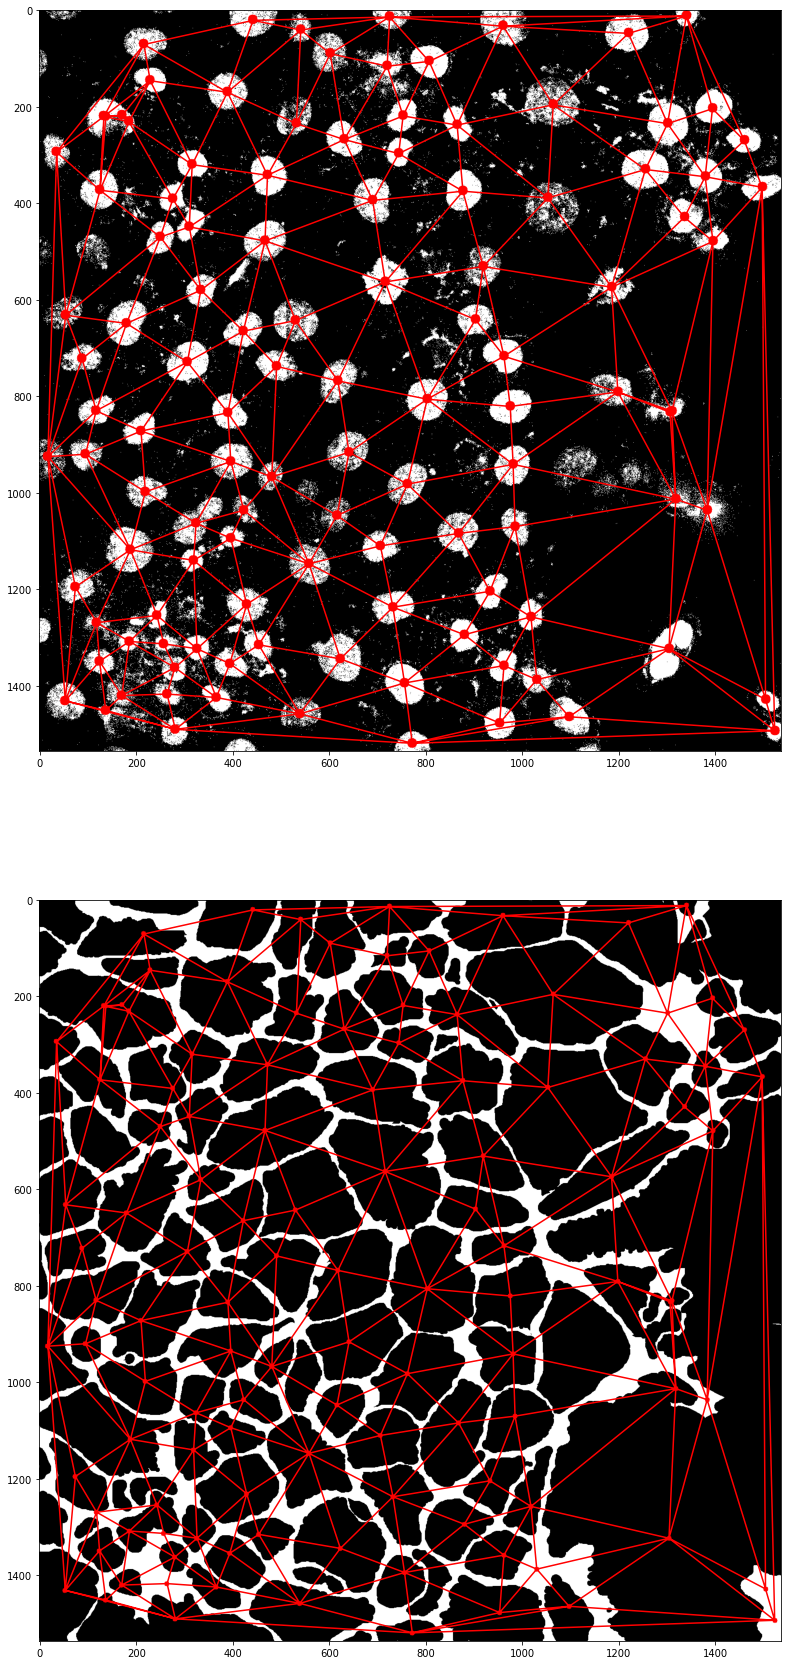

In [8]:
tri = Delaunay(centroids)
fig, axes = plt.subplots(2, figsize=(15,30))
axes[0].imshow(bin_nuclei_centroids)
axes[0].triplot(centroids[:,0], centroids[:,1], tri.simplices, 'r-')

axes[1].imshow(jbin_centroids)
axes[1].triplot(centroids[:,0], centroids[:,1], tri.simplices, 'r-')

In [118]:
edges_refs = []
for simplex in tri.simplices:
    edge_ref_1 = np.array((simplex[0], simplex[1]))
    edge_ref_2 = np.array((simplex[1], simplex[2]))
    edge_ref_3 = np.array((simplex[2], simplex[0]))
    
    edge_ref_1.sort()
    edge_ref_2.sort()
    edge_ref_3.sort()
    
    edges_refs.append(edge_ref_1)
    edges_refs.append(edge_ref_2)
    edges_refs.append(edge_ref_3)
    

In [119]:
edges_refs = np.unique(edges_points, axis=0)
edges_refs.shape

(330, 2)

In [120]:
edges = centroids[edges_refs]
edges.shape

(330, 2, 2)

In [175]:
from skimage.draw import line
lines = []
for edge in edges:
    rr, cc = line(edge[0,0], edge[0,1], edge[1,0], edge[1,1])
    lines.append((rr,cc))

In [125]:
new_nuclei = np.copy(nuclei_centroids)
new_jbin = np.copy(jbin_centroids)

for rr, cc in lines:
    new_nuclei[cc, rr] = (255, 0, 0)
    new_jbin[cc, rr] = (255, 0, 0)

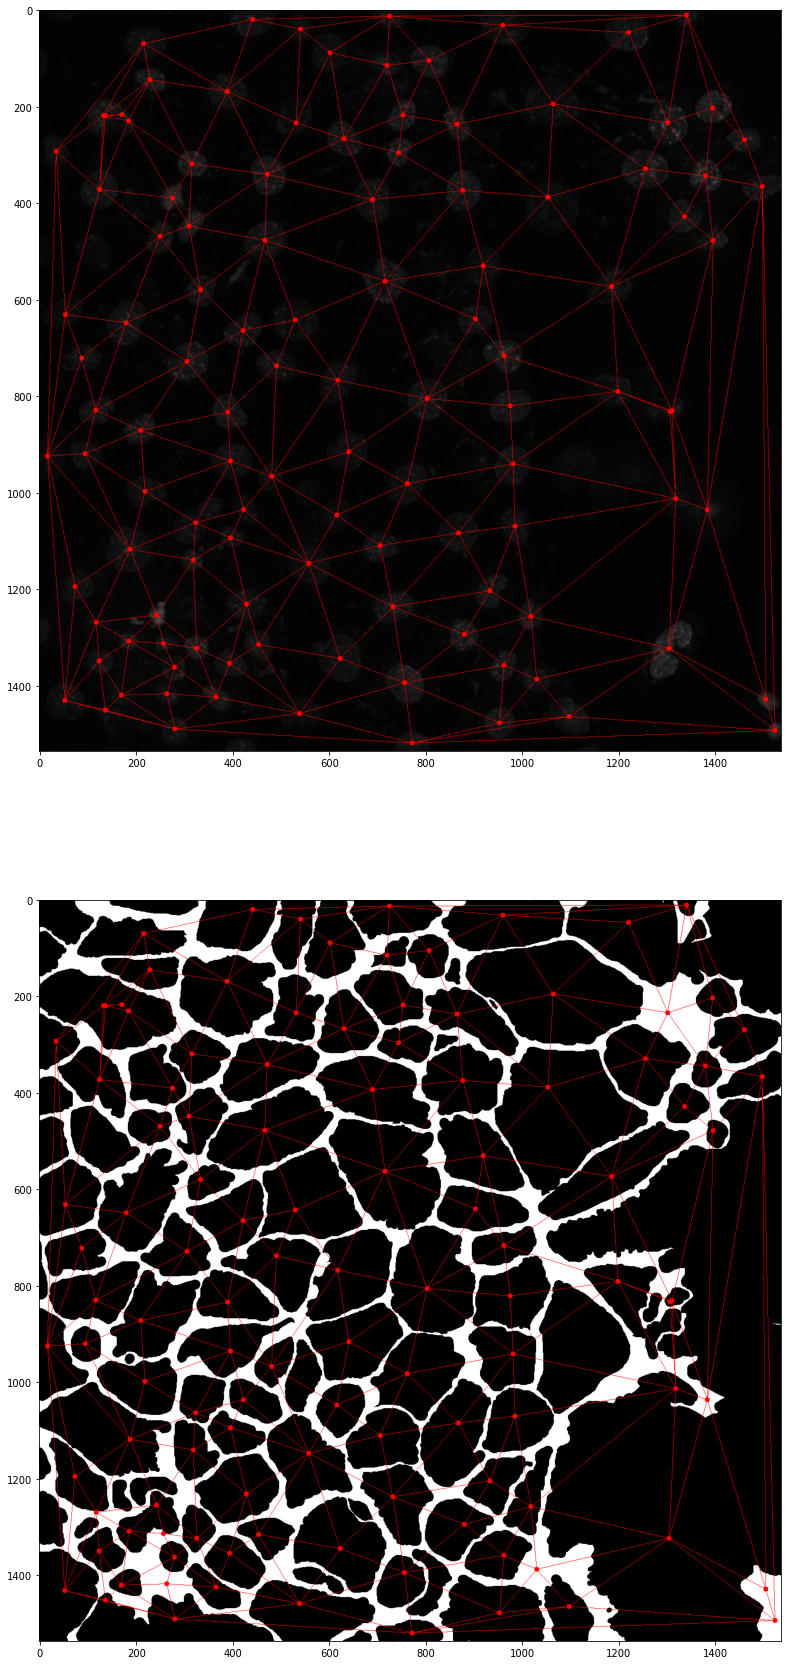

In [126]:
fig, ax = plt.subplots(2, figsize=(15,30))
ax[0].imshow(new_nuclei)
ax[1].imshow(new_jbin)

In [174]:
false_lines = []
false_centroids_refs = []
for index, segment in enumerate(lines):
    rr, cc = segment
    segment_img = jbin_img[cc, rr]
    if not np.any(segment_img == 255):
        false_lines.append([rr, cc])
        false_centroids_refs.append(edges_refs[index])

In [156]:
np.array(false_centroids_refs)

array([[ 11,  12],
       [ 11,  15],
       [ 12,  15],
       [ 12,  17],
       [ 15,  17],
       [ 18,  24],
       [102, 103]], dtype=int32)

In [143]:
false_centroids_refs = np.unique(np.array(false_centroids_refs).flatten())
false_centroids_refs

array([ 11,  12,  15,  17,  18,  24, 102, 103], dtype=int32)

In [128]:
false_jbin = np.copy(jbin_centroids)
false_zeros = np.zeros_like(jbin_centroids)
for rr, cc in false_lines:
    false_jbin[cc, rr] = (0, 255, 0)
    false_zeros[cc, rr] = (0, 255, 0)
    

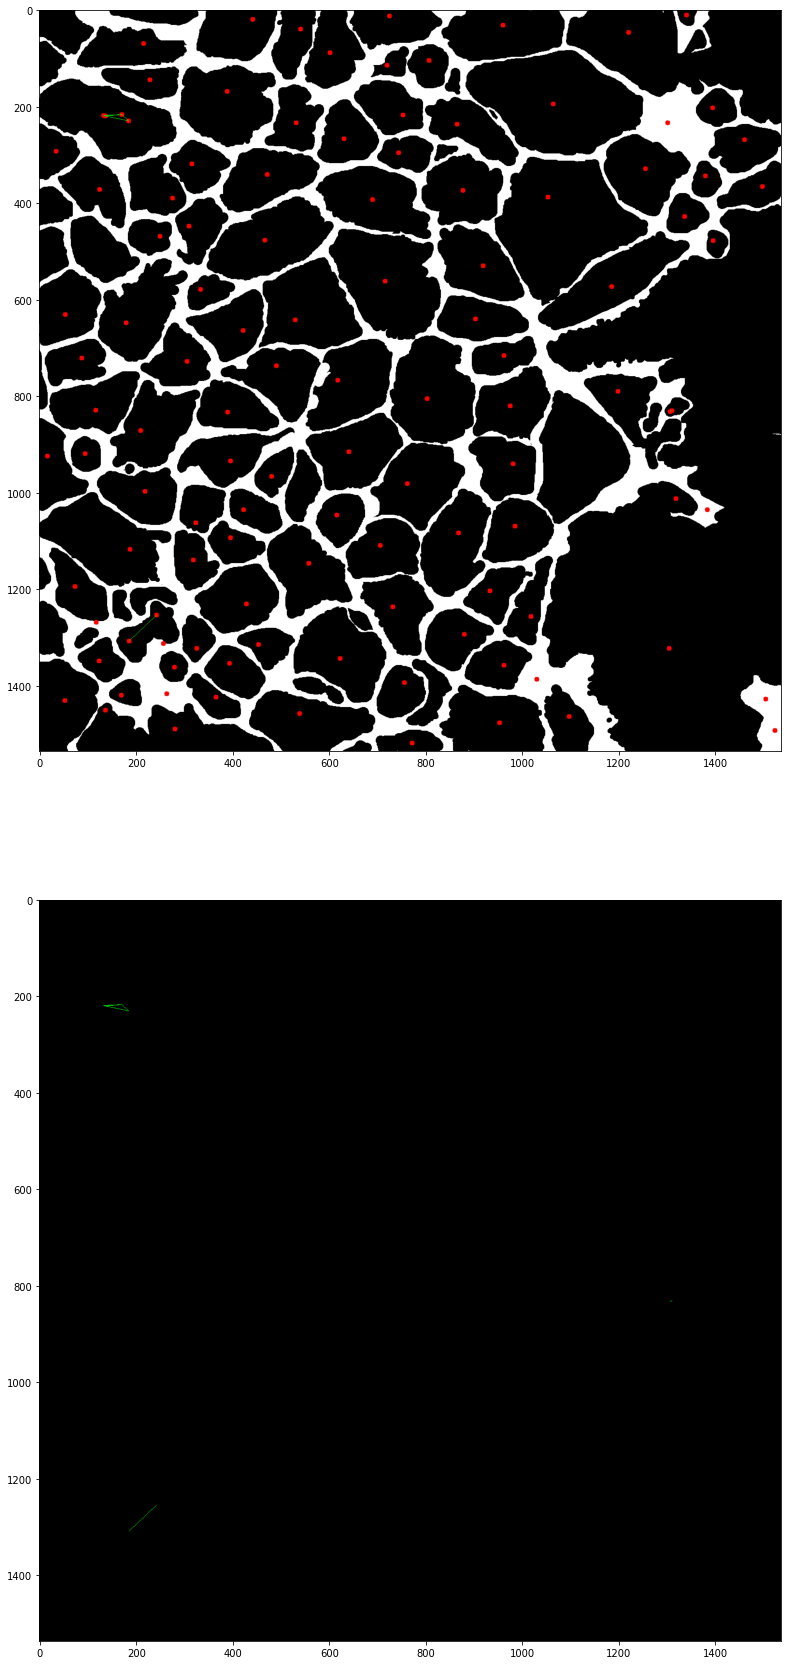

In [148]:
fig, ax = plt.subplots(2, figsize=(15,30))
ax[0].imshow(false_jbin)
ax[1].imshow(false_zeros)

In [146]:
false_centroids = np.copy(nuclei_centroids)
for ref in false_centroids_refs:
    x, y = centroids[ref]
    cv2.circle(false_centroids, (x, y), 5, (0, 255, 0), -1)


133 220
137 221
171 218
185 231
186 1308
243 1254
1306 833
1310 831


In [158]:
from scipy.spatial import cKDTree

radio = 5
kdtree = cKDTree(centroids)
rows_to_fuse = np.array(list(kdtree.query_pairs(r=radio)))
rows_to_fuse, rows_to_fuse.shape, centroids[rows_to_fuse]

(array([[ 11,  12],
        [102, 103]]),
 (2, 2),
 array([[[ 136,  220],
         [ 137,  221]],
 
        [[1309,  831],
         [1310,  831]]]))

In [153]:
for rows in rows_to_fuse:
    centroids[rows[0]] = (centroids[rows[0]] + centroids[rows[1]]) / 2

mask = np.ones(len(centroids), dtype=bool)
mask[rows_to_fuse[:, 1]] = False
centroids_2 = centroids[mask]
centroids_2.shape, centroids.shape

((113, 2), (115, 2))

In [185]:
def merge_centroids(centroids, rows_to_fuse):
    if len(rows_to_fuse) == 0:
        return centroids
    for rows in rows_to_fuse:
        centroids[rows[0]] = (centroids[rows[0]] + centroids[rows[1]]) / 2
    
    mask = np.ones(len(centroids), dtype=bool)
    mask[rows_to_fuse[:, 1]] = False
    return centroids[mask]

def remove_close_centroids(centroids, radio=10):
    kdtree = cKDTree(centroids)
    rows_to_fuse = np.array(list(kdtree.query_pairs(r=radio)))
    merged_centroids = merge_centroids(centroids, rows_to_fuse)
    return merged_centroids


def get_edges_indexes_delaunay(delaunay_tri):
    '''Gets all the unique edges in the Delaunay triangulation.
    
    Returns the indexes of the points that forms each edge. The indexes are relative to 
    the list of points stored in the Delaunay triangulation.
    '''
    # We get the references to the points that forms every edge
    edges_refs = []
    for simplex in delaunay_tri.simplices:
        edge_ref_1 = np.array((simplex[0], simplex[1]))
        edge_ref_2 = np.array((simplex[1], simplex[2]))
        edge_ref_3 = np.array((simplex[2], simplex[0]))

        # We sort the points, so that we can later delete the duplicates
        edge_ref_1.sort()
        edge_ref_2.sort()
        edge_ref_3.sort()

        edges_refs.append(edge_ref_1)
        edges_refs.append(edge_ref_2)
        edges_refs.append(edge_ref_3)

    # Remove the duplicates
    edges_refs = np.unique(edges_refs, axis=0)
    return edges_refs

def get_indexes_false_centroids(segments, edges_refs, bin_img):
    '''Returns the indexes of those centroids that have at least one adjacent 
    centroid with no cell-cell junction in between.
    '''
    # We check that every segment contains at least one white pixel
    # If it doesn't, it means that there is no cell-cell junction between the two centroids
    false_centroids_indexes = []
    for index, segment in enumerate(segments):
        rr, cc = segment
        segment_img = bin_img[cc, rr]
        if not np.any(segment_img == 255):
            false_centroids_indexes.append(edges_refs[index])
    return np.array(false_centroids_indexes)


def clean_centroids_delaunay(centroids, bin_img):
    # Delaunay triangulation
    tri = Delaunay(centroids)
    edges_refs = get_edges_indexes_delaunay(tri)

    # Now we get the real coords that forms every edge, not just the references
    edges = centroids[edges_refs]
    
    # We get the actual segments. Not just the two points, but the whole line
    interp_segments = []
    for edge in edges:
        rr, cc = line(edge[0,0], edge[0,1], edge[1,0], edge[1,1])
        interp_segments.append((rr,cc))
    false_centroids_indexes = get_indexes_false_centroids(interp_segments, edges_refs, bin_img)
    merged_centroids = merge_centroids(centroids, false_centroids_indexes)
    return merged_centroids
    

def clean_centroids(centroids, bin_img, n_iter=3, radio=10):
    for index in range(n_iter):
        print("########## Iteration {} ########## ".format(index + 1))
        print("N centroids: {}".format(len(centroids)))
        centroids = remove_close_centroids(centroids, radio)
        print("N centroids after removing close points: {}".format(len(centroids)))
        centroids = clean_centroids_delaunay(centroids, bin_img)
        print("N centroids after Delaunay analysis: {}".format(len(centroids)))
    return centroids


In [186]:
centroids = get_nuclei_centroids(nuclei_img)
cleaned_centroids = clean_centroids(centroids, jbin_img)

########## Iteration 1 ########## 
N centroids: 115
N centroids after removing close points: 113
N centroids after Delaunay analysis: 110
########## Iteration 2 ########## 
N centroids: 110
N centroids after removing close points: 110
N centroids after Delaunay analysis: 110
########## Iteration 3 ########## 
N centroids: 110
N centroids after removing close points: 110
N centroids after Delaunay analysis: 110


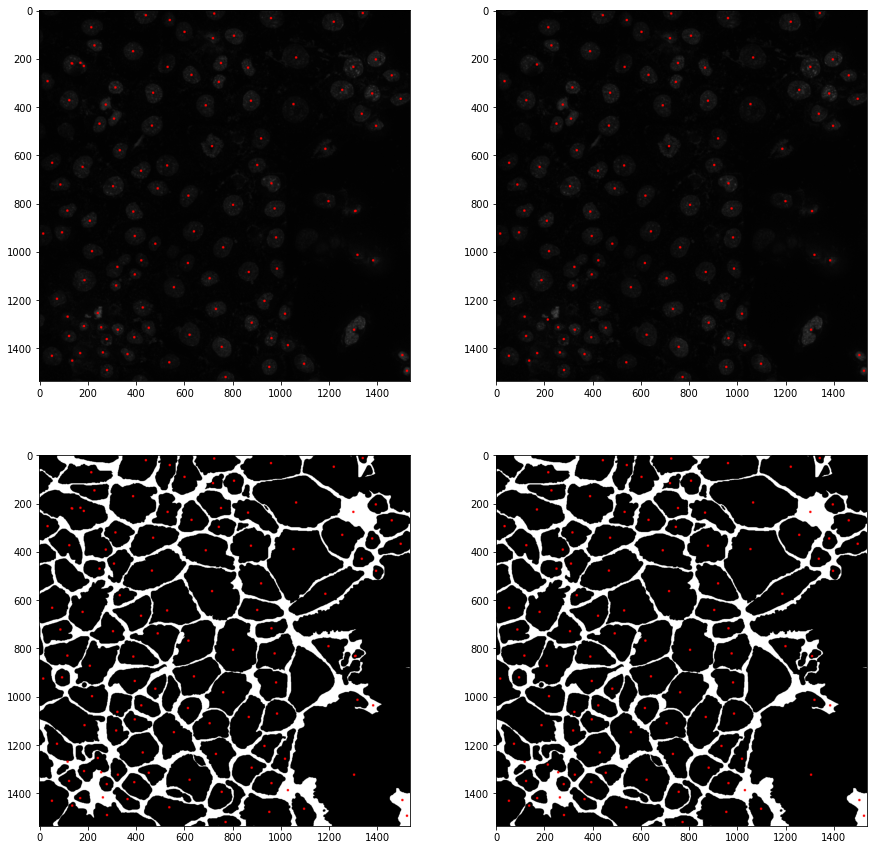

In [187]:
nuclei_centroids_final = np.copy(nuclei_img)
jbin_centroids_final = np.copy(jbin_img)

for x, y in centroids:
    cv2.circle(nuclei_centroids_final, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids_final, (x, y), 5, (255, 0, 0), -1)

nuclei_centroids_final_cleaned = np.copy(nuclei_img)
jbin_centroids_final_cleaned = np.copy(jbin_img)

for x, y in cleaned_centroids:
    cv2.circle(nuclei_centroids_final_cleaned, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids_final_cleaned, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids_final)
ax[0,1].imshow(nuclei_centroids_final_cleaned)
ax[1,0].imshow(jbin_centroids_final)
ax[1,1].imshow(jbin_centroids_final_cleaned)
